# Data Exploration 4

Create train and test data for the project by combining and processing two data set

1. Trump tweet archieve data (json file from http://www.trumptwitterarchive.com)

2. SPY market data (TAQ) (csv file from https://wrds-web.wharton.upenn.edu/wrds)

## Final data format

dataframe with the following fields:

- tweet_time (datetime index)
- text (tweet text content)
- retweet_count
- favorite_count 
- id_str (twitter ID)
- DTmin (np.array of delta minutes wrt tweet time for price data)
- SPY (np.array of SPY price data at DTmin)
- PP (np.array of SPY movement in percentage point (PP) at DTmin)


In [1]:
# import packages

import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import pickle


In [2]:
# All Functions

def load_twdata(TW_PATH):
    twdf = pd.read_json(TW_PATH, encoding='utf-8')
    twdf['created_at'] = pd.to_datetime(twdf['created_at']).dt.tz_convert('US/Eastern')
    twdf = twdf.set_index('created_at')
    return twdf

def load_taqdata(TAQ_PATH):
    df = pd.read_csv(TAQ_PATH)
    df = df[['DATE','TIME_M','SIZE','PRICE']]
    df['TIME_M'] = pd.to_datetime(df['DATE'].map(str) + ' ' + df['TIME_M']).dt.tz_localize('US/Eastern')
    df = df.set_index('TIME_M')
    df = df[['SIZE', 'PRICE']]
    return df

def is_market_hour(twtime):
    """
    Inputs:
        twtime: tweet time (datetime obj)
    """
    # WEEKDAY and HOUR 9:30-16:00
    #market_hr = (twtime.weekday()<5) and (twtime.hour > 9) and (twtime.hour < 16)
    market_hr = (twtime.weekday()<5) and ( (twtime.hour > 10) or (twtime.hour==9 and twtime.minute>30) ) and (twtime.hour < 16)
    return market_hr

def data_combine_tw_taq(tw_df, taq_df, dtminus=60, dtplus=60, RESAMPLE_INT=1, REF_OFFSET=0, PRINT_THRES=.5):
    """
    Combine tweet data and TAQ data into one dataframe, formatted to be analysed by deep learning model
    Inputs:
        tw_df : pd DataFRame obj containing TW data
        taq_df : pd DataFrame obj containing TAQ price data
        dtmius : offset to start taking data to the left (minutes)
        dtplus : offset to stop taking data to the right (minutes)
        RESAMPLE_INT : resampling interval (minutes) (0 = no resampling)
        REF_OFFSET : offset (minutes before tweet time) to take price reference for PP calculation
        PRINT_THRES : threshold to print out movement change (+/-) beyond this value (percentage point (pp))
    Outputs:
        out_df : cropped DataFrame for specified time periods
    """
    
    # looping over tweet time
    
    df_compile = None
    
    plt.figure()
    
    for timeidx in tw_df.index:
        #print(timeidx)
        #print(tw_df.loc[timeidx,'is_retweet'])
        #check for timestamps with multiple frames
            
        # check within market hour
        if is_market_hour(timeidx) :
            
            #crop taq_df around timeidx
            tleft = timeidx + datetime.timedelta(minutes=-dtminus-1)
            tright = timeidx + datetime.timedelta(minutes=dtplus+1)
            taq_df_crop = taq_df[tleft:tright]
            
            if len(taq_df_crop) > 0:
                
                if RESAMPLE_INT > 0:
                    taq_df_crop = taq_df_crop.resample('60S', base=timeidx.second).mean().fillna(method='ffill')
                    
                tleft =  timeidx + datetime.timedelta(minutes=-60)
                tright = timeidx + datetime.timedelta(minutes=60)
                taq_df_crop = taq_df_crop[tleft:tright]

                DTmin = taq_df_crop.index - timeidx
                DTmin = DTmin.total_seconds() / 60
                DTmin = np.array(DTmin)

                SPY = np.array( taq_df_crop.PRICE )
                
                ind = np.abs(DTmin+REF_OFFSET).argmin()
                Pref = SPY[ind]
                #print(timeidx, ind, type(SPY), SPY, type(Pref), Pref)
                PP =  ((SPY*1.0/Pref) - 1) * 100
                
                """
                In case multiple tweets have the same time stamp : combine tweet texts, keep ID and counts
                of original tweet (last in tw dataframe). 
                Yeah, I know, who sends two tweets at exactly the same time, right? It happens.
                """
                D = tw_df.loc[timeidx].ndim
                if D == 1:
                    N = 1
                else:
                    N = len( tw_df.loc[timeidx] )
                
                if N == 1:
                    retw_cnt = tw_df.loc[timeidx,'retweet_count']
                    fav_cnt = tw_df.loc[timeidx,'favorite_count']
                    id_str = tw_df.loc[timeidx,'id_str']
                    ctext = tw_df.loc[timeidx,'text']
                else:
                    retw_cnt = tw_df.loc[timeidx,'retweet_count'][-1]
                    fav_cnt = tw_df.loc[timeidx,'favorite_count'][-1]
                    id_str = tw_df.loc[timeidx,'id_str'][-1]
                    tmp = []
                    for i in range( N ):
                        tmp.append( tw_df.text[timeidx][-i-1] )
                    ctext = ' '.join(tmp)

                #print(N, timeidx)
                dfnew = pd.DataFrame({'DTmin':[DTmin], 'SPY':[SPY], 'PP':[PP], \
                                      'text':[ctext], \
                                      'retweet_count':[ retw_cnt ], \
                                      'favorite_count':[ fav_cnt ], \
                                      'id_str':[ id_str ] } ,\
                                     index=[timeidx])
                                
                if df_compile is None:
                    df_compile = dfnew
                else:
                    df_compile = df_compile.append(dfnew)
                    
                # print out
                
                if np.abs(PP[-1]) > PRINT_THRES:
                    print(timeidx, PP[-1], tw_df.loc[timeidx, 'text'])

                plt.plot(DTmin, 100*PP)
    
    plt.ylim([-100,100])
    plt.xlabel('min since tweet sent')
    plt.ylabel('SPY change [bp]')
    plt.show()
    
    return df_compile


data\TWARCH_NORT_2017.json loaded.
data\TAQ_2017.csv loaded.


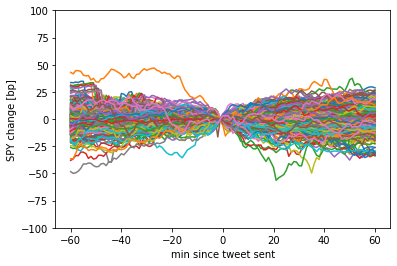

2017 done.
data\TWARCH_NORT_2018H1.json loaded.
data\TAQ_2018H1.csv loaded.


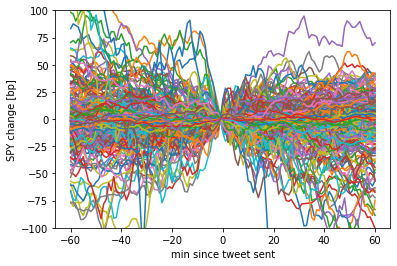

2018H1 done.
data\TWARCH_NORT_2018H2.json loaded.
data\TAQ_2018H2.csv loaded.


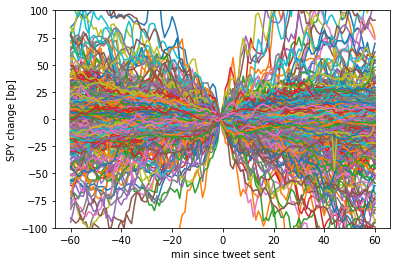

2018H2 done.
data\TWARCH_NORT_2019.json loaded.
data\TAQ_2019.csv loaded.


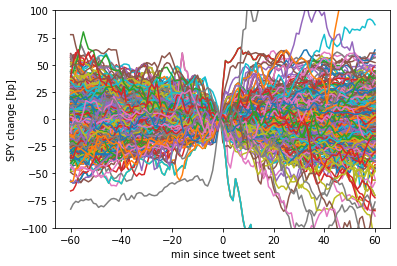

2019 done.


In [25]:
YEARS = ['2017', '2018H1', '2018H2', '2019']
#YEARS = ['2018H2', '2019']

for year in YEARS:
    
    TW_PATH = 'data\TWARCH_NORT_' + year + '.json'
    tw_df = load_twdata(TW_PATH)
    print('%s loaded.' % TW_PATH)

    SPY_PATH = 'data\TAQ_' + year + '.csv'
    taq_df = load_taqdata(SPY_PATH)
    print('%s loaded.' % SPY_PATH)

    df = data_combine_tw_taq(tw_df, taq_df, 60, 60, 1, 1, 20)

    with open('CombinedTWTAQ_' + year + '.pkl', 'wb') as outfile:
        pickle.dump(df, outfile)
        
    print('%s done.' % year)


In [30]:
df

,DTmin,SPY,BP,text,retweet_count,favorite_count,id_str
2019-11-20 14:04:30-05:00,"[-60.0, -59.0, -58.0, -57.0, -56.0, -55.0, -54...","[310.03703639290876, 309.9684079999957, 309.85...","[0.9743089379132819, -1.2394613986010938, -4.8...",I WANT NOTHING! https://t.co/KKUfwSIRAi,17288,63654,1197229247930097664
2019-11-20 13:57:07-05:00,"[-60.0, -59.0, -58.0, -57.0, -56.0, -55.0, -54...","[310.2191705846459, 309.85582280083264, 310.02...","[8.677657246070059, -3.045121970984832, 2.3168...",....â€�I WANT NOTHING! I WANT NOTHING! I WANT ...,19734,74280,1197227388683206656
2019-11-20 13:57:06-05:00,"[-60.0, -59.0, -58.0, -57.0, -56.0, -55.0, -54...","[310.2208562347605, 309.85808491449313, 310.02...","[8.784879002712298, -2.919363416373777, 2.3108...",Impeachment Witch Hunt is now OVER! Ambassador...,25184,97677,1197227384878927872
2019-11-20 13:45:36-05:00,"[-60.0, -59.0, -58.0, -57.0, -56.0, -55.0, -54...","[311.3254382608698, 311.2779941391941, 311.264...","[58.405240523955456, 56.87240014714323, 56.434...",We join families of Kevin King &amp; Tim Weeks...,14346,52994,1197224490192629760
2019-11-20 13:03:40-05:00,"[-60.0, -59.0, -58.0, -57.0, -56.0, -55.0, -54...","[311.1891295819932, 311.28258171262706, 311.28...","[31.184101922434593, 34.19653210714024, 34.145...",https://t.co/HbgEgZsPZ9,15506,51152,1197213939030867968
...,...,...,...,...,...,...,...
2019-01-03 12:40:49-05:00,"[-60.0, -59.0, -58.0, -57.0, -56.0, -55.0, -54...","[247.34447460245434, 247.67987813079344, 247.8...","[38.697179396056654, 52.309832192560805, 59.32...",The RNC has a great Chairwoman in Ronna McDani...,18243,90159,1080881680779542528
2019-01-03 11:10:31-05:00,"[-60.0, -59.0, -58.0, -57.0, -56.0, -55.0, -54...","[245.65951496840344, 245.65737124524668, 245.3...","[10.71903545802666, 10.631677920847071, -2.603...",https://t.co/JzfXMAPwKP,54075,202291,1080858959404240896
2019-01-03 09:52:13-05:00,"[-60.0, -59.0, -58.0, -57.0, -56.0, -55.0, -54...","[248.17095238095234, 248.2242857142854, 248.20...","[48.37382159404102, 50.53327363845117, 49.8798...",The United States Treasury has taken in MANY b...,22311,106376,1080839254656405504
2019-01-03 09:44:19-05:00,"[-60.0, -59.0, -58.0, -57.0, -56.0, -55.0, -54...","[247.52225806451622, 247.7508771929824, 247.81...","[-11.445272231174197, -2.219537566521268, 0.17...",The Shutdown is only because of the 2020 Presi...,30482,129182,1080837263913832448


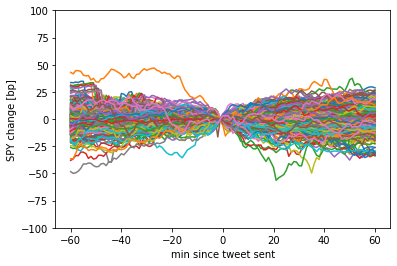

TIME_M
2017-01-03 04:00:00.014959-05:00    224.80
2017-01-03 04:00:00.014982-05:00    224.80
2017-01-03 04:00:00.015009-05:00    224.80
2017-01-03 04:00:00.015034-05:00    224.80
2017-01-03 04:00:00.015058-05:00    224.80
                                     ...  
2017-12-29 19:59:52.816553-05:00    266.00
2017-12-29 19:59:53.709765-05:00    266.00
2017-12-29 19:59:56.350563-05:00    266.00
2017-12-29 20:00:00.004460-05:00    266.86
2017-12-29 20:00:00.004484-05:00    266.86
Name: PRICE, Length: 54002290, dtype: float64

In [24]:
df = data_combine_tw_taq(tw_df, taq_df, 60, 60, 1, 1, 20)
taq_df.PRICE

In [12]:
year = '2019'
TW_PATH = 'data\TWARCH_NORT_' + year + '.json'
tw_df = load_twdata(TW_PATH)
tw_df['2019-03-18 11:07:40-04:00'].text.values

array(['Wow! A Suffolk/USA Today Poll, just out, states, “50% of Americans AGREE that  Robert Mueller’s investigation is a Witch Hunt.” @MSNBC  Very few think it is legit! We will soon find out?'],
      dtype=object)

## Check that time stamps match

Summer time (no daylight saving)
2019-05-10

Daylight saving
2019-01-09

Cross-check with tweeter : passed


2019-11-20 13:45:36-05:00 34.44368472276693 We join families of Kevin King &amp; Tim Weeks in celebrating their release from Taliban captivity. Thanks to President Ghani for his courageous support. Let’s hope this leads to more good things on the peace front like a ceasefire that will help end this long war. Proud of my team!
2019-11-01 09:38:39-04:00 21.50100695432533 ISIS has a new leader. We know exactly who he is!
2019-11-01 09:33:50-04:00 24.7322453176535 “The Democrats are so immersed in this (SCAM). They couldn’t care less about the American people!” @RushLimbaughEIB
2019-10-30 15:49:44-04:00 24.045213024475043 We will be having a big rally for Governor @MattBevin on Monday night in Kentucky. Get your tickets today! https://t.co/uoPhCLGHpH
2019-10-30 14:44:32-04:00 33.74205545756625 created_at
2019-10-30 14:44:32-04:00    ....Your current Governor, John Bel Edwards, h...
2019-10-30 14:44:32-04:00    Early voting in Louisiana for a man who will b...
Name: text, dtype: object
2019

2019-09-27 15:41:18-04:00 24.09181967730545 I AM DRAINING THE SWAMP! https://t.co/U7WxKrO6Kx
2019-09-27 11:24:05-04:00 -44.82082595654191 If that perfect phone call with the President of Ukraine Isn’t considered appropriate, then no future President can EVER again speak to another foreign leader!
2019-09-27 09:32:06-04:00 -28.839284251130913 The Democrats are now to be known as the DO NOTHING PARTY!
2019-09-25 09:59:22-04:00 37.686051161922585 https://t.co/coIrRDN33G
2019-09-24 14:12:11-04:00 37.6361931516267 ....You will see it was a very friendly and totally appropriate call. No pressure and, unlike Joe Biden and his son, NO quid pro quo! This is nothing more than a continuation of the Greatest and most Destructive Witch Hunt of all time!
2019-09-24 14:12:09-04:00 37.40872302919085 I am currently at the United Nations representing our Country, but have authorized the release tomorrow of the complete, fully declassified and unredacted transcript of my phone conversation with President

2019-08-06 13:51:24-04:00 24.99192376542725 ...in 2020.” Lou Dobbs stated that this is a fraud on the American public. @peterschweizer stated with certainty that they suppressed negative stories on Hillary Clinton, and boosted negative stories on Donald Trump. All very illegal. We are watching Google very closely!
2019-08-06 13:51:23-04:00 24.995313367650596 created_at
2019-08-06 13:51:23-04:00    ... are NOT planning to illegally subvert the ...
2019-08-06 13:51:23-04:00    .@sundarpichai of Google was in the Oval Offic...
Name: text, dtype: object
2019-08-06 13:51:23-04:00 24.995313367650596 created_at
2019-08-06 13:51:23-04:00    ... are NOT planning to illegally subvert the ...
2019-08-06 13:51:23-04:00    .@sundarpichai of Google was in the Oval Offic...
Name: text, dtype: object
2019-08-06 12:28:23-04:00 39.970096042794 Thank you @JimCramer @CNBC! https://t.co/DW7HDA0WEK
2019-08-06 12:24:54-04:00 42.09074732816287 Thank you Mr. Wonderful, I like you too! @kevinolearytv @CNBC http

2019-05-31 15:12:32-04:00 -23.04862646353878 created_at
2019-05-31 15:12:32-04:00    ....on the basis of their sexual orientation. ...
2019-05-31 15:12:32-04:00    As we celebrate LGBT Pride Month and recognize...
Name: text, dtype: object
2019-05-28 15:38:00-04:00 -22.118120836753796 Storms overnight across Ohio and many other States were very dangerous and damaging. My team continues to update me with reports from emergency managers in the States affected. Listen to your local officials and be resilient. We are with you!
2019-05-20 14:07:30-04:00 -31.417435109515335 Fred Keller of the Great State of Pennsylvania has been an outstanding State Representative. Now he is running as the Republican Nominee for Congress, and has my Complete and Total Endorsement. He will do a fantastic job - I look forward to seeing everyone tonight! #MAGA
2019-05-20 13:40:23-04:00 -30.210836355747396 See you tonight at 7:00 P.M. Eastern, Montoursville, Pennsylvania! #MAGA https://t.co/Ij2AjXfRZa
2019-05-17

2019-03-07 09:38:54-05:00 -43.45767277129653 We are on track to APPREHEND more than one million people coming across the Southern Border this year. Great job by Border Patrol (and others) who are working in a Broken System. Can be fixed by Congress so easily and quickly if only the Democrats would get on board!
2019-03-04 15:17:23-05:00 24.93643027833281 “There is no Collusion. All of these investigations are in search of a crime. Democrats have no evidence to impeach President Trump. Ridiculous!” @DevinNunes @FoxNews
2019-03-04 15:06:34-05:00 31.04474880101238 “Now that the Dems are going to try &amp; switch from Collusion to some other reason, it makes them continue to look like sore losers who didn’t accept the WILL OF THE PEOPLE in the last election - they will do anything to get rid of the President.” @AriFleischer It will never work!
2019-03-04 11:17:28-05:00 -106.77393526866364 FEMA has been told directly by me to give the A Plus treatment to the Great State of Alabama and the w

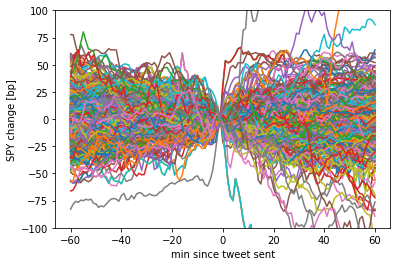

In [3]:
year = '2019'

TW_PATH = 'data\TWARCH_NORT_' + year + '.json'
tw_df = load_twdata(TW_PATH)

SPY_PATH = 'data\TAQ_' + year + '.csv'
taq_df = load_taqdata(SPY_PATH)

df = data_combine_tw_taq(tw_df, taq_df, 60, 60, 1, 1, 20)

In [21]:
#date = '2019-01-09' #done timing correct for daylight saving
date = '2019-05-10' #daytime saving correct as well
print(df.loc[date,'SPY'])
print(df.loc[date,'SPY'].values)
print(tw_df.loc[date,'text'])

2019-05-10 15:14:04-04:00    [286.60530630630547, 286.4808447646488, 286.41...
2019-05-10 15:14:04-04:00    [286.60530630630547, 286.4808447646488, 286.41...
2019-05-10 13:57:00-04:00    [285.39408395989886, 285.4950172284641, 285.46...
2019-05-10 09:39:11-04:00    [285.05258064516136, 285.05157894736845, 285.0...
Name: SPY, dtype: object
[array([286.60530631, 286.48084476, 286.41248575, 286.29353116,
       286.22563105, 286.21056732, 286.39179991, 286.42210423,
       286.33962346, 286.23630999, 286.19268958, 286.1690415 ,
       286.12276297, 286.30578032, 286.32331291, 286.34595148,
       286.40192756, 286.37675412, 286.48725213, 286.51175153,
       286.43189913, 286.42007013, 286.37312142, 286.5368708 ,
       286.58598383, 286.63678823, 286.76453409, 286.71204707,
       286.67966492, 286.75963098, 286.67321957, 286.68223921,
       286.77075682, 286.81102113, 286.88470012, 286.85015051,
       286.96646522, 287.05452333, 287.22225656, 287.33497861,
       287.20735443, 287.196

In [25]:
#tmp = taq_df[date+' 14:34':date+' 16:34'].resample('1min').mean().fillna('interpolate')
tmp = taq_df[date+' 12:57':date+' 14:57'].resample('1min').mean().fillna('interpolate')
print(tmp)

                                 SIZE       PRICE
TIME_M                                           
2019-05-10 12:57:00-04:00  141.077694  285.394084
2019-05-10 12:58:00-04:00  155.983770  285.495017
2019-05-10 12:59:00-04:00  156.033791  285.460874
2019-05-10 13:00:00-04:00  179.024291  285.299392
2019-05-10 13:01:00-04:00  125.539535  285.423220
...                               ...         ...
2019-05-10 14:53:00-04:00  193.046251  287.333979
2019-05-10 14:54:00-04:00  192.100437  287.217499
2019-05-10 14:55:00-04:00  152.003670  287.198509
2019-05-10 14:56:00-04:00  376.098338  287.120864
2019-05-10 14:57:00-04:00  254.733970  287.060616

[121 rows x 2 columns]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001AA47A3A978>,
      dtype=object)

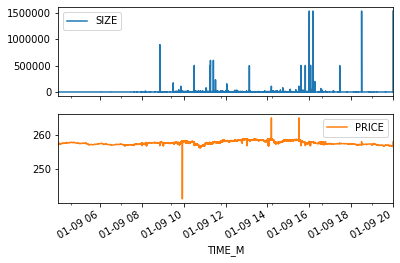

In [11]:
taq_df[date].plot(subplots=True)

In [128]:
df['2018-12-14']

,DTmin,SPY,BP,text,retweet_count,favorite_count,id_str
2018-12-14 13:19:36-05:00,"[-60.0, -59.0, -58.0, -57.0, -56.0, -55.0, -54...","[261.7462566731144, 261.7273937677047, 261.814...","[-3.4632526309974487, -4.183659216698832, -0.8...",Thank you to @tim_cook for agreeing to expand ...,13212,60963,1073643684212682752
2018-12-14 13:17:32-05:00,"[-60.0, -59.0, -58.0, -57.0, -56.0, -55.0, -54...","[261.5817235609102, 261.75553992467303, 261.75...","[-12.19701534055817, -5.560299391368373, -5.73...",Many people have asked how we are doing in our...,13960,70466,1073643165318635520
2018-12-14 13:17:32-05:00,"[-60.0, -59.0, -58.0, -57.0, -56.0, -55.0, -54...","[261.5817235609102, 261.75553992467303, 261.75...","[-12.19701534055817, -5.560299391368373, -5.73...",Many people have asked how we are doing in our...,13960,70466,1073643165318635520
2018-12-14 11:35:43-05:00,"[-60.0, -59.0, -58.0, -57.0, -56.0, -55.0, -54...","[262.6505049261084, 262.74981690580694, 262.84...","[1.0093971202462804, 4.790924372557459, 8.4246...",China just announced that their economy is gro...,27243,128368,1073617541476569088
2018-12-14 11:25:59-05:00,"[-60.0, -59.0, -58.0, -57.0, -56.0, -55.0, -54...","[263.46575059263915, 263.1280157471898, 263.12...","[52.51252722061173, 39.62628391528167, 39.5891...",China just announce the there economy is growi...,2749,10439,1073615092028203008


## Combine process dataframes, divide into training and test sets

- Processed dataframes : data\CombinedTWTAQ_*year*.pkl where year = '2017', '2018H1', '2018H2', '2019'
- Combine dataframes, drop duplicates
- saved all, training, test sets

In [9]:
from sklearn.model_selection import train_test_split

def load_processed_df(PATH):
    with open(PATH, 'rb') as infile:
        df = pickle.load(infile)
    return df

def sqrt_mse(y):
    return np.sqrt( np.sum( np.square(y) ) / len(y) )

In [4]:
YEARS = ['2017', '2018H1', '2018H2', '2019']
frames = []
for year in YEARS:
    path = 'data\CombinedTWTAQ_' + year + '.pkl'
    df = load_processed_df(path)
    print(len(df))
    frames.append(df)

df_all = pd.concat(frames)
df_all = df_all.drop_duplicates(subset='id_str')

with open('CombinedTWTAQ_all.pkl', 'wb') as outfile:
    pickle.dump(df_all, outfile)

337
236
377
758


In [11]:
df_all.head()

def df_to_xy(df):
    x = df.text
    y = df.PP.apply(lambda xx: xx[75])
    return (x,y)

_,y = df_to_xy(df_all)

print(sqrt_mse(y))

0.15168004118757145

In [12]:
df_train, df_test = train_test_split(df_all, test_size=300, random_state=200)
_,y = df_to_xy(df_train)
print(len(df_train),sqrt_mse(y))
_,y = df_to_xy(df_test)
print(len(df_test),sqrt_mse(y))

with open('CombinedTWTAQ_train.pkl', 'wb') as outfile:
    pickle.dump(df_train, outfile)
    
with open('CombinedTWTAQ_test.pkl', 'wb') as outfile:
    pickle.dump(df_test, outfile)

1345 0.15146427676045165
300 0.15264363624391106


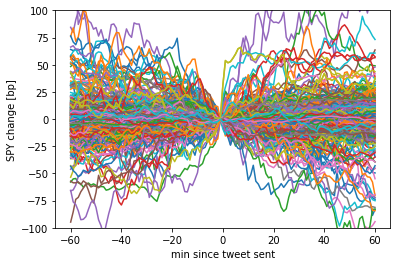

In [40]:
plt.figure()

for timeidx in df_test.index:
    plt.plot(df_test.loc[timeidx,'DTmin'], 100*df_test.loc[timeidx,'PP'])
    
plt.ylim([-100,100])
plt.xlabel('min since tweet sent')
plt.ylabel('SPY change [bp]')
plt.show()

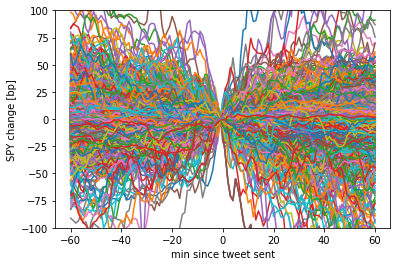

In [41]:
plt.figure()

for timeidx in df_train.index:
    plt.plot(df_train.loc[timeidx,'DTmin'], 100*df_train.loc[timeidx,'PP'])
    
plt.ylim([-100,100])
plt.xlabel('min since tweet sent')
plt.ylabel('SPY change [bp]')
plt.show()